<a href="https://colab.research.google.com/github/t108368071/MyProject/blob/master/4_GRU_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks/
df_all = pd.read_csv("gru_low.csv") 

#num_features = ['cardiac_period', 'SUT', 'DT', 'DW_10', 'DW_25', 'DW_33', 'DW_50', 'DW_66','DW_75', 'SW_10 + DW_10', 'SW_10/DW_10', 'SW_25 + DW_25', 'SW_25/DW_25', 'SW_33 + DW_33', 'SW_33/DW_33','SW_50 + DW_50', 'SW_50 / DW_50', 'SW_66 + DW_66', 'SW_66 / DW_66','SW_75 + DW_75', 'SW_75 / DW_75','area','area_s','area_d']

#正常特徵
#num_features = ['cardiac_period', 'SUT', 'DT','SW_25 + DW_25','SW_75 + DW_75','DW_50','SW_50 + DW_50','area_d']

#高血壓特徵
#num_features = ['cardiac_period','DT','area_d','area_s','SW_50 + DW_50','DW_33','SW_33/DW_33','SW_10/DW_10']

#低血壓特徵
num_features = ['cardiac_period','DT','area_d','area_s','SUT','area','SW_10/DW_10','SW_25/DW_25']

#混和特徵
#num_features = ['cardiac_period','SUT', 'DT','DW_50','SW_75 / DW_75','area_d','DW_75', 'SW_10/DW_10']

#target = ['systolic']
target = ['systolic','diastolic']

df = df_all[num_features + target]
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks


,cardiac_period,DT,area_d,area_s,SUT,area,SW_10/DW_10,SW_25/DW_25,systolic,diastolic
0,91,63,0.810213,0.407793,35,1.240813,0.300000,0.500000,87.801905,52.556102
1,90,69,0.880192,0.394999,33,1.298010,0.301887,0.520000,86.121672,52.790553
2,92,60,0.840106,0.308852,21,1.173220,0.312500,0.285714,88.192656,52.907779
3,92,71,0.854964,0.385932,32,1.262827,0.304348,0.292683,85.301094,52.907779
4,90,68,0.882233,0.300477,21,1.205533,0.294118,0.520000,86.317048,52.751478


In [ ]:
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

In [ ]:
df = normalize(df)
df

,cardiac_period,DT,area_d,area_s,SUT,area,SW_10/DW_10,SW_25/DW_25,systolic,diastolic
0,0.411765,0.511628,0.442904,0.681965,0.913043,0.485605,0.167241,0.378364,0.592283,0.064660
1,0.392157,0.651163,0.533626,0.651973,0.826087,0.537280,0.169486,0.400861,0.536093,0.070591
2,0.431373,0.441860,0.481657,0.450027,0.304348,0.424536,0.182112,0.137321,0.605351,0.073556
3,0.431373,0.697674,0.500920,0.630717,0.782609,0.505493,0.172414,0.145160,0.508651,0.073556
4,0.392157,0.627907,0.536272,0.430393,0.304348,0.453730,0.160243,0.400861,0.542626,0.069603
...,...,...,...,...,...,...,...,...,...,...
13382,0.431373,0.558140,0.314417,0.394059,0.521739,0.280607,0.199687,0.244451,0.790594,0.761533
13383,0.352941,0.465116,0.485571,0.612798,0.565217,0.488325,0.226724,0.220883,0.702387,0.761533
13384,0.333333,0.488372,0.539673,0.771765,0.565217,0.588061,0.405172,0.483820,0.712188,0.723230
13385,0.372549,0.488372,0.506724,0.719243,0.608696,0.542840,0.239401,0.477617,0.842865,0.878913


In [ ]:
def buildTrain(train, pastDay=5, futureDay=1):
  X_train, Y_train = [], []
  for i in range(train.shape[0]-futureDay-pastDay):
    X_train.append(np.array(train.iloc[i:i+pastDay]))
    Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay][["systolic","diastolic"]]))
  return np.array(X_train), np.array(Y_train)

def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]


def splitData(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val

In [ ]:
# build Data, use last 10 days to predict next 1 days
X_train, Y_train = buildTrain(df, 10, 1)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.25)
X_val, Y_val, X_test, Y_test = splitData(X_val, Y_val, 0.585)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(10032, 10, 10)
(10032, 1, 2)
(1388, 10, 10)
(1388, 1, 2)
(1956, 10, 10)
(1956, 1, 2)


In [ ]:
Y_train=Y_train.reshape(X_train.shape[0],2)
Y_val=Y_val.reshape(X_val.shape[0],2)
Y_test=Y_test.reshape(X_test.shape[0],2)

In [ ]:
from keras import optimizers,Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

def buildManyToOneModel(shape):
  model = Sequential()
  model.add(GRU(200, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  model.add(GRU(400))
  model.add(Dense(2,activation='relu'))
  opt = optimizers.Adam(learning_rate=0.0001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  return model

In [ ]:
model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor='loss', min_delta=0.001, patience=100,  verbose=1, mode='min')
#history=model.fit(X_train, Y_train, epochs=500, batch_size=64, validation_data=(X_val, Y_val), callbacks=[callback])
history=model.fit(X_train, Y_train, epochs=500, batch_size=64,callbacks=[callback])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 10, 200)           127200    
_________________________________________________________________
gru_9 (GRU)                  (None, 400)               722400    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 802       
Total params: 850,402
Trainable params: 850,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
157/157 [==============================] - 4s 5ms/step - loss: 0.0265
Epoch 2/500
157/157 [==============================] - 1s 5ms/step - loss: 0.0034
Epoch 3/500
157/157 [==============================] - 1s 5ms/step - loss: 0.0034
Epoch 4/500
157/157 [==============================] - 1s 5ms/step - loss: 0.0032
Epoch 5/500
157/157 [=============================

In [ ]:
#高血壓
#SBP_MIN = 133.002
#SBP_RANGE = 56.9817
#DBP_MIN = 65.0016
#DBP_RANGE = 34.9919
#低血壓
SBP_MIN = 70.0913
SBP_RANGE = 29.9023
DBP_MIN = 50
DBP_RANGE = 39.5312

In [ ]:
SBP_Ans = Y_test[:,0]
DBP_Ans = Y_test[:,1]
O_SBP = (SBP_Ans * SBP_RANGE) + SBP_MIN  
O_DBP = (DBP_Ans * DBP_RANGE) + DBP_MIN  

In [ ]:
testPredict = model.predict(X_test)
SBP = testPredict[:,0]
DBP = testPredict[:,1]
P_SBP = (SBP * SBP_RANGE) + SBP_MIN  
P_DBP = (DBP * DBP_RANGE) + DBP_MIN  

MAE SBP: 1.2822573788028409 SD:1.5995927181710508 MAE DBP: 1.037957121072758 SD:1.1308034288083322


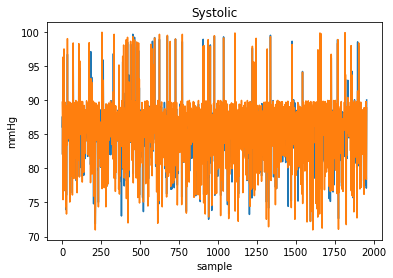

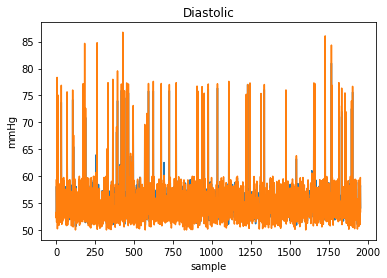

In [ ]:
from sklearn.metrics import mean_absolute_error

error_sbp = P_SBP - O_SBP
error_dbp = P_DBP - O_DBP

mae_error_sbp = mean_absolute_error(P_SBP,O_SBP)
mae_error_dbp = mean_absolute_error(P_DBP,O_DBP)

error_sbp_std = np.std(abs(error_sbp)) 
error_dbp_std = np.std(abs(error_dbp)) 

print(f"MAE SBP: {mae_error_sbp} SD:{error_sbp_std} MAE DBP: {mae_error_dbp} SD:{error_dbp_std}")

plt.figure(1)
plt.title("Systolic")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(P_SBP)
plt.plot(O_SBP)

plt.figure(2)
plt.title("Diastolic")
plt.xlabel("sample") 
plt.ylabel("mmHg")
plt.plot(P_DBP)
plt.plot(O_DBP)

In [ ]:
np.savetxt('gru_low_分布圖_0722.csv',np.column_stack((O_SBP,P_SBP,O_DBP,P_DBP)),delimiter=',')

In [ ]:
trainPredict = model.predict(X_train)
trainSBP_Ans = Y_train[:,0]
trainDBP_Ans = Y_train[:,1]
train_O_SBP = (trainSBP_Ans * SBP_RANGE) + SBP_MIN  
train_O_DBP = (trainDBP_Ans * DBP_RANGE) + DBP_MIN

trainSBP = trainPredict[:,0]
trainDBP = trainPredict[:,1]
train_P_SBP = (trainSBP * SBP_RANGE) + SBP_MIN  
train_P_DBP = (trainDBP * DBP_RANGE) + DBP_MIN 

MAE SBP: 0.21857103515062629 SD:0.188038225185247 MAE DBP: 0.2532130660377661 SD:0.20816886004759874


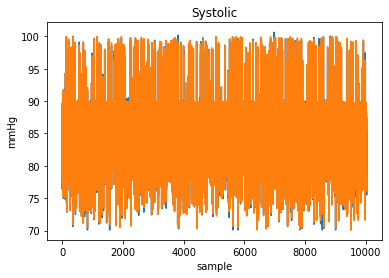

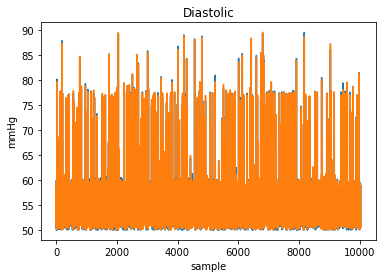

In [ ]:
train_error_sbp = train_P_SBP - train_O_SBP
train_error_dbp = train_P_DBP - train_O_DBP

train_mae_error_sbp = mean_absolute_error(train_P_SBP,train_O_SBP)
train_mae_error_dbp = mean_absolute_error(train_P_DBP,train_O_DBP)

train_error_sbp_std = np.std(abs(train_error_sbp)) 
train_error_dbp_std = np.std(abs(train_error_dbp)) 

print(f"MAE SBP: {train_mae_error_sbp} SD:{train_error_sbp_std} MAE DBP: {train_mae_error_dbp} SD:{train_error_dbp_std}")

plt.figure(1)
plt.title("Systolic")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(train_P_SBP)
plt.plot(train_O_SBP)

plt.figure(2)
plt.title("Diastolic")
plt.xlabel("sample") 
plt.ylabel("mmHg")
plt.plot(train_P_DBP)
plt.plot(train_O_DBP)

In [ ]:
np.save('GRU_low_Feature',X_train)
np.save('GRU_low_Feature_test',X_test)
np.save('GRU_low_error_sbp',train_error_sbp)
np.save('GRU_low_error_dbp',train_error_dbp)
np.save('GRU_low_actual_sbp',O_SBP)
np.save('GRU_low_actual_dbp',O_DBP)
np.save('GRU_low_predict_sbp',P_SBP)
np.save('GRU_low_predict_dbp',P_DBP)

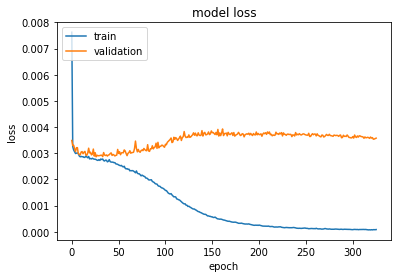

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()